In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(os.path.join("drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))
os.getcwd()

'/content/drive/Othercomputers/My Laptop/RP/urban-change-detection'

In [3]:
!pip install -r requirements.txt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

#### Imports


In [4]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from visualize import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import levir_dataset_loader
import train_test
from levir_dataset_loader import LEVIR_Dataset
import time
from train_test import train
reload(metrics)

<module 'metrics' from '/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py'>

#### Load Data

In [5]:
N_EPOCHS = 10
FP_MODIFIER = 1
BATCH_SIZE = 32
PATCH_SIDE = 512
STRIDE = 50
TEST_RUN = False
DIRNAME = os.path.join("..", "data", "LEVIR-CD - Toy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import torch
from torch.autograd import Variable
from metrics import evaluate_net_predictions
from tqdm import tqdm as tqdm
import time


def train(net, net_name, train_dataset, train_loader, val_dataset, criterion, n_epochs = 10, save = True, save_dir=f'{time.time()}.pth.tar'):

    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    epoch_metrics = {"train": [], "val": []}

    for _ in range(n_epochs):
        net.train()

        for batch in tqdm(train_loader):
            I1 = Variable(batch['I1'].float().to(device))
            I2 = Variable(batch['I2'].float().to(device))
            label = Variable(batch['label'].float().to(device))


            optimizer.zero_grad()
            output = torch.round(net(I1, I2))

            # print(output.shape, label.shape)
            # print(output, label)
            label /= 255
            label = label.long()
            loss = criterion(torch.round(output), label)

            loss.backward()
            optimizer.step()

        scheduler.step()

        epoch_metrics['train'].append(evaluate_net_predictions(net, criterion, train_dataset))
        epoch_metrics['val'].append(evaluate_net_predictions(net, criterion, val_dataset))


    if save:

        torch.save(net.state_dict(), save_dir)


    return epoch_metrics




In [7]:
train_dataset = LEVIR_Dataset(DIRNAME, "train", STRIDE, PATCH_SIDE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = torch.FloatTensor(train_dataset.weights).to(device)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

test_dataset = LEVIR_Dataset(DIRNAME, "test", STRIDE, PATCH_SIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

val_dataset = LEVIR_Dataset(DIRNAME, "val", STRIDE, PATCH_SIDE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

net, net_name = FresUNet(2 * 3, 2), 'FresUNet'
net.to(device)
criterion = nn.NLLLoss(weight=weights)

In [114]:
%env TORCH_USE_CUDA_DSA=1

save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics = train(net, net_name, train_dataset, train_loader, val_dataset, criterion, n_epochs=5, save=True, save_dir = save_dir)


env: TORCH_USE_CUDA_DSA=1


  0%|          | 0/38 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 38/38 [00:54<00:00,  1.43s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 38/38 [00:54<00:00,  1.44s/it]


In [115]:
test_metrics = evaluate_net_predictions(net, criterion, test_dataset)

/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py:80: RuntimeWarning: invalid value encountered in scalar divide
  prec = tp / (tp + fp)


In [116]:
test_metrics

{'net_loss': -1.0073920488357544,
 'net_accuracy': 99.16372299194336,
 'class_accuracy': [100.00000762939453, 0.0],
 'precision': nan,
 'recall': 0.0}

/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/visualization/visualize.py:23: RuntimeWarning: invalid value encountered in scalar divide
  train_f1 = [2 * p * r / (p + r) for p, r in zip(train_precision, train_recall)]


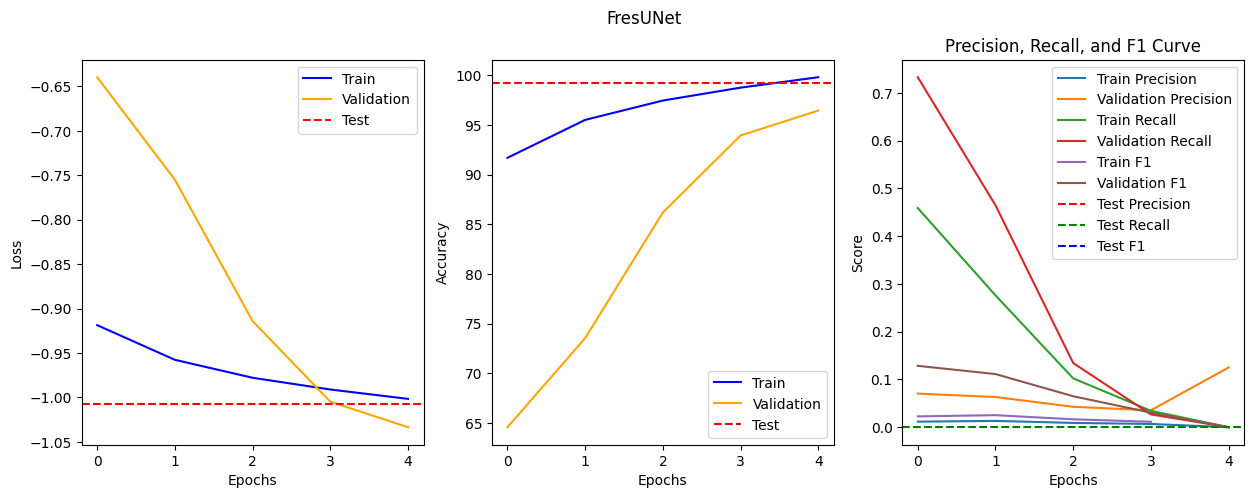

In [117]:
import tables
import visualize
from tables import create_tables
from visualize import create_figures

reload(tables)
reload(visualize)

create_figures(training_metrics, test_metrics, net_name)
create_tables(training_metrics, test_metrics, net_name)